In [1]:
import numpy as np
import pandas as pd
from Show import *

# Importing information

In [2]:
#Import pics information
data_info = pd.read_csv('dataset_images_minitest.csv',sep='\t')

In [3]:
# Information about data_info

print("Data size is:", len(data_info))
print("Columns:", *data_info.columns)
print("Categories:", *data_info.category.unique())
display(data_info.sample(5))

Data size is: 20987
Columns: filename category
Categories: graduation picnic meeting


,filename,category
7092,10706585955_870c793740.jpg,picnic
7027,10168385453_4538f8f69d.jpg,picnic
20702,8579821036_c325e822b1.jpg,meeting
18141,5107216004_abaefafce1.jpg,meeting
8330,18763909553_bdbdf56e0b.jpg,picnic


# Preparing the images

In [4]:
from keras import backend as K # Keras backend information file. 
from Image import * #Image generator extension

/home/agata/anaconda3/envs/machine_learning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
img_dest_size = (150,150)
#Standart image configuration
if K.image_data_format() == 'channels_first':
    input_shape = (3, *img_dest_size)
else:
    input_shape = (*img_dest_size, 3)

In [6]:
#Creating the generators
datagen = ImageDataGeneratorPlus(rescale=1. / 255,horizontal_flip=True)

#adding the images from pandas
generator=datagen.flow_from_pandas(data_info,'pics/',target_size=img_dest_size)

Found 20987 images belonging to 3 classes.
Actually, found 20987 images belonging to 3 classes


## Generating from batches

In [7]:
import time

In [ ]:
n_classes = generator.num_classes
x = []
y = []
start = time.time()
generator.reset()
for xb,yb in generator:
    x+= list(xb)
    y+= list(yb)
    dt = time.time()-start
    if (generator.batch_index==0) or dt>5*60:
        print(dt)
        break
x = np.asarray(x)
y = np.asarray(y)

176.78793025016785


In [ ]:
#saving the data
import pickle

with open("x.pickle","wb") as f:
    pickle.dump(x, f)

with open("y.pickle","wb") as f:
    pickle.dump(y, f)

In [ ]:
generator.class_indices

In [ ]:
#loading the data
import pickle

with open("X_train.pickle","rb") as f:
    x_train = pickle.load(f)

with open("y_train.pickle","rb") as f:
    y_train = pickle.load(f)
    
    
class_indices = {'graduation': 0, 'meeting': 1, 'picnic': 2}
c_i = {int(value):key for key,value in class_indices.items()}

In [ ]:
x.shape

# Visualisando 

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
n = np.random.randint(0,len(x_train))
print(c_i[np.dot(y_train[n],[0,1,2]).astype('int')])
print(y_train[n])
plt.imshow(x_train[n])
plt.show()

In [ ]:
from collections import Counter
train_classes_division = Counter(np.dot(y_train,[0,1,2]).astype('int'))
test_classes_division = Counter(np.dot(y_test,[0,1,2]).astype('int'))
print('Os dados estão divididos em')
total = sum(train_classes_division.elements())
for n,qty in train_classes_division.items():
    print('\t{:10}:{:>3}%'.format(c_i[n],(qty*100)//total))

# Montando a rede

In [28]:
img_dest_size = x.shape[1:3]
epochs = 10 
batch_size = 64
#Standart image configuration
if K.image_data_format() == 'channels_first':
    input_shape = (3, *img_dest_size)
else:
    input_shape = (*img_dest_size, 3)

In [29]:
from keras.models import Sequential  # for a sequential model 
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

In [32]:
#Model definition
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape,activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64,activation='relu'))
    #model.add(Dropout(0.9))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return model

In [32]:
history = model.fit(x, y, batch_size=batch_size, epochs=epochs,validation_split=0.3,verbose=0)

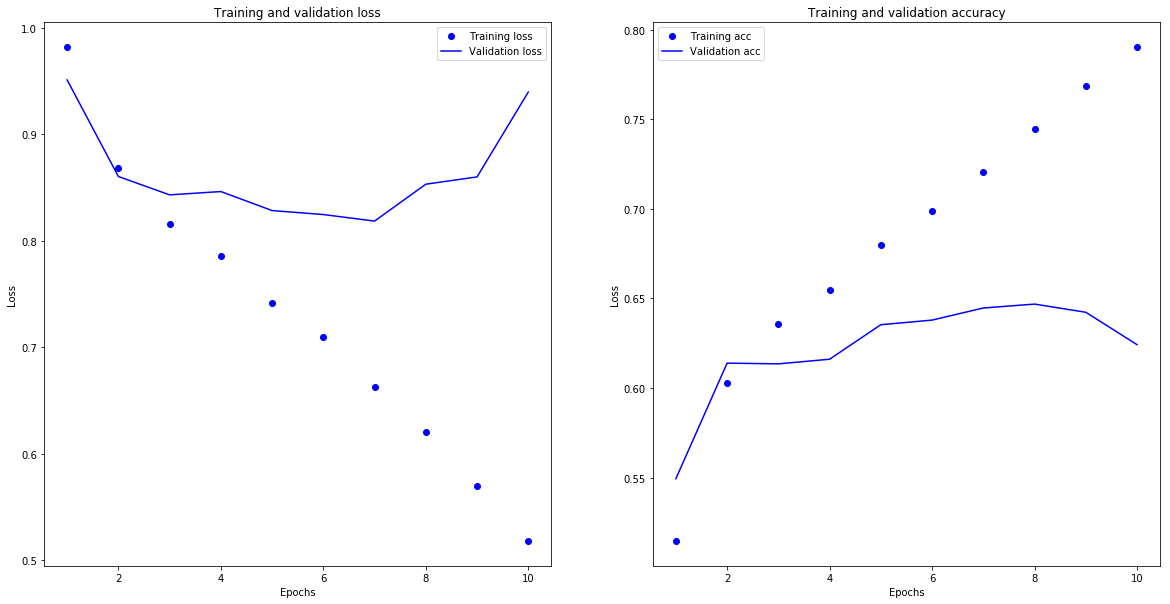

In [33]:
#https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_vec = range(1,len(acc)+1)
plt.figure(figsize=(20,10))
plt.subplot(121)
# "bo" is for "blue dot"
plt.plot(epochs_vec, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs_vec, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs_vec, acc, 'bo', label='Training acc')
plt.plot(epochs_vec, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Nitidamente há um overfitting nas primeiras épocas. 

# Cuva ROC

In [17]:
#Calculating the ROC curve

#create y_test
y_testc = y_test
print('Prediction')
#Create the prediction
y_score = model.predict(x_test)
print('finish')

Prediction
finish


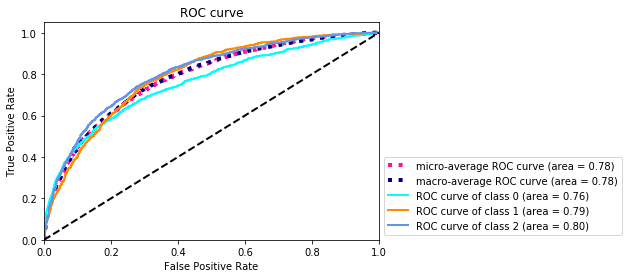

In [18]:
#Based on https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2
n_classes=3

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_testc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_testc.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower left", bbox_to_anchor=(1, 0))
plt.show()